2500


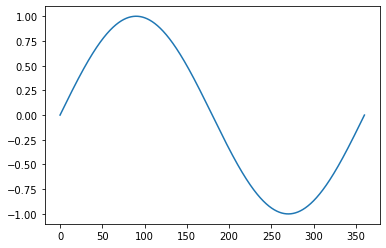

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

def dcos(angle):
    angle = np.deg2rad(angle)
    return np.cos(angle)

def dsin(angle):
    angle = np.deg2rad(angle)
    return np.sin(angle)

def dtan(angle):
    angle = np.deg2rad(angle)
    return np.tan(angle)

# 1. Stress State

class StressState:
    def __init__(self, Sv, SH, Sh, SH_azimuth, custom_angle=None):
        """
        Class to define stress state object
        :param Sv: Vertical stress magnitude
        :param SH: Maximum horizontal stress magnitude
        :param Sh: Minimum horizontal stress magnitude
        :param SH_azimuth: azimuth SH in N-E
        :param custom_angle: alpha, beta, gamma (euler angle)
        """
        self.principal, self.regime = self._stress_matrix(Sv, SH, Sh)
        R = self._principal2geo(*self._euler_angle(self.regime, SH_azimuth))

        if custom_angle:
            R = self._principal2geo(*custom_angle)

        self.ned = R.T @ self.principal @ R

    def _stress_matrix(self, Sv, SH, Sh):
        '''
        Returns matrix form of stress tensor
        in principal coordinate system
        :param Sv: Vertical Stress
        :param SH: Maximum Horizontal Stress
        :param Sh: Minimum Horizontal Stress
        :return: S (3x3) diagonal matrix in coordinate
        S1, S2, S3
        '''
        if Sv >= SH >= Sh:
            regime = 'NF'
        elif SH >= Sv >= Sh:
            regime = 'SS'
        elif SH >= Sh >= Sv:
            regime = 'RF'

        S = -np.sort(-np.array([Sv, SH, Sh]))
        return np.diag(S), regime

    @staticmethod
    def _principal2geo(a, b, g):
        """
        Create rotation matrix (R) to rotate from
        principal coordinate system (xs, ys, zs) to
        NED (North-East-Down) coordinate system (x, y, z)
        using three euler angle (three-step)
        rotation.
        :param a: rotation angle (in degree) about z axis
        :param b: rotation angle (in degree) about y' axis
        :param g: rotation angle (in degree) about x'' axis
        :return: rotation matrix (R) 3x3 matrix to rotate principal
        to geographical coordinate system using equation R.T @ S @ R
        where S is stress tensor in principal coordinate system
        """
        R = np.array([[dcos(a) * dcos(b), dsin(a) * dcos(b), -dsin(b)],
                      [dcos(a) * dsin(b) * dsin(g) - dsin(a) * dcos(g),
                       dsin(a) * dsin(b) * dsin(g) + dcos(a) * dcos(g),
                       dcos(b) * dsin(g)],
                      [dcos(a) * dsin(b) * dcos(g) + dsin(a) * dsin(g),
                       dsin(a) * dsin(b) * dcos(g) - dcos(a) * dsin(g),
                       dcos(b) * dcos(g)]])
        return R

    def _euler_angle(self, regime, SH_azimuth):
        if regime == 'NF':
            angles = (SH_azimuth + 90, 90, 0)

        elif regime == 'SS':
            angles = (SH_azimuth, 0, 90)

        elif regime == 'RF':
            angles = (SH_azimuth, 0, 0)

        return angles

# 2. Faults

class FaultPlane:
    """
    This class estimates traction vector in a fault plane
    given a stress state and orientation of a fault in strike and dip
    strike-dip convention uses right hand rule convention,
    """
    def __init__(self, strike, dip):
        self.strike = strike
        self.dip = dip

        # plane's normal, dip, and strike vectors
        self.nn, self.nd, self.ns = self._fault_parameters(strike, dip)

    def _fault_parameters(self, strike, dip):
        """
        This helper function calculate basis vectors in fault plane 
        coordinate system 
        
        (x1, x2, x3) = (normal, dip, strike)
        Args:
            strike (float/int): strike of the fault 
            dip (float/int): dip of the fault plane
        Returns:
            numpy arrays (ndim 3x1): return three numpy arrays, 
            each array corresponds to basis vector that points to 
            a plane's normal, strike, and dip  
        """
        # normal vector
        nn = np.array([[-dsin(strike) * dsin(dip),
                        dcos(strike) * dsin(dip),
                        -dcos(dip)]])

        # strike vector
        ns = np.array([[dcos(strike),
                        dsin(strike),
                        0]])

        # dip vector
        nd = np.array([[-dsin(strike) * dcos(dip),
                        dcos(strike) * dcos(dip),
                        dsin(dip)]])

        return nn.T, nd.T, ns.T

    def stress2plane(self, stress_state:StressState):
        """
        Given a stress state as an input, this method
        projects that stress state to local fault coordinate
        Args:
            stress_state (StressState instance): instance of a StressState class
        Returns:
            dict : dictionary that contains traction vector for a particular combination of 
            fault plane and stress state, contains following vectors and scalars
            1. traction (vector) : the total traction
            2. normal (vector): traction projected to plane's normal direction
            3. shear_dip (vector): shear traction projected along dip direction
            4. shear_strike (vector): shear traction projected along strike direction
            5. abs_shear (scalar): magnitude of shear_dip + shear_strike 
            6. rake (scalar) : slip direction measured along the fault plane
        """
        traction = stress_state.ned @ self.nn
        normal = traction.T.dot(self.nn)[0]
        shear_dip = traction.T.dot(self.nd)[0]
        shear_strike = traction.T.dot(self.ns)[0]
        abs_shear = np.sqrt(shear_dip ** 2 + shear_strike ** 2)
        rake = np.rad2deg(np.arctan(shear_dip / shear_strike))

        self.stress = {'traction': traction, 'normal': normal,
                       'shear_dip': shear_dip, 'shear_strike': shear_strike,
                       'abs_shear': abs_shear, 'rake': rake}
        return self

# 3. Borehole
def _geo2wellbore(inc, azi):
    R = np.array([[-dcos(azi) * dcos(inc), -dsin(azi) * dcos(inc), dsin(inc)],
                  [dsin(azi), -dcos(azi), 0],
                  [dcos(azi) * dsin(inc), dsin(azi) * dsin(inc), dcos(inc)]])
    return R

def kirsch(r, t, stress_state, Pp, Pw, pr):
    """
    Kirsch equation for stress along circular cavity
    Args:
        r ([int]/[numpy array]): 
        t ([int]/[numpy array]): theta along borehole, 0 starts at SHmax (in vertical borehole)
            and from bottom of the hole (in deviated hole)
        stress_state ([numpy ndarray]): 3x3 array representing stress tensor
        Pp ([float/int]): Pore Pressure
        Pw ([float/int]): Wellbore Pressure
        pr ([float/int]): Poisson's ratio
    Returns:
        [type]: [description]
    """
    ss = stress_state - np.eye(3) * Pp
    sx = ss[0, 0]
    sy = ss[1, 1]
    sz_ = ss[2, 2]
    txy = ss[0, 1]
    txz = ss[0, 2]
    tyz = ss[1, 2]

    dp = Pw - Pp
    a = (sx + sy) / 2
    b = (sx - sy) / 2
    c0 = 1 / r ** 2
    c1n = 1 - 1 / r ** 2
    c1p = 1 + 1 / r ** 2

    # radial
    cr = 1 + 3 / r ** 4 - 4 / r ** 2
    sr = a * c1n + b * cr * dcos(2 * t) + txy * cr * dsin(2 * t) + dp * c0

    # tangential
    ct = 1 + 3 / r ** 4
    st = a * c1p - b * ct * dcos(2 * t) - txy * ct * dsin(2 * t) - dp * c0

    # vertical
    sz = sz_ - pr * (4 * b * c0 * dcos(2 * t) + 4 * txy * c0 * dsin(2 * t))

    # shear rt
    crt = 1 - 3 / r ** 4 + 2 / r ** 2
    trt = b * crt * dsin(2 * t) + txy * crt * dcos(2 * t)

    # shear tz
    ttz = (-txz * dsin(t) + tyz * dcos(t)) * c1p

    # shear rz
    trz = (txz * dcos(t) + tyz * dsin(t)) * (c1n)

    return sr, st, sz, trt, ttz, trz


class Wellbore:
    def __init__(self, stress_state, inc=0, azi=0):
        self.inc = inc
        self.azi = azi
        self.Sw = self.geo2wellbore(stress_state.ned, inc, azi)

    @staticmethod
    def geo2wellbore(Sg, inc, azi):
        R = _geo2wellbore(inc, azi)
        return R @ Sg @ R.T

    def wall_stress(self, r, t, Pp, Pw, pr, principal=False):
        # stresses = kirsch(r, t, self.Sw, Pp, Pw, pr)
        srr, stt, szz, trt, ttz, trz = kirsch(r, t, self.Sw, Pp, Pw, pr)
        if principal == True:
            if self.inc == 0:
                s1, s2, s3 = self._to_principal_vertical(srr, stt, szz, trt)

            else:
                s1, s2, s3 = self._to_principal_deviated(szz, stt, srr, ttz)
            return s1, s2, s3

        else:
            return srr, stt, szz, trt, ttz, trz 

    @staticmethod
    def _to_principal_vertical(srr, stt, szz, trt):
        C = (stt + srr)*0.5
        R = np.sqrt(((stt-srr)*0.5)**2 + trt**2)
        # s1, s2, s3 = -np.sort(-np.array([C+R, C-R, szz]), axis=0)
        s1 = C+R 
        s2 = szz 
        s3 = C-R
        return s1, s2, s3
    
    @staticmethod
    def _to_principal_deviated(szz, stt, srr, ttz):
        C = (stt + szz)*0.5
        R = np.sqrt(((szz - stt)*0.5)**2 + ttz**2)
        # s1, s2, s3 = -np.sort(-np.array([C+R, C-R, srr]), axis=0)
        s1 = C+R 
        s2 = srr 
        s3 = C-R
        return s1, s2, s3

    def breakout_width(self, Pp, Pw, pr, mu, ucs):
        q = (np.sqrt(mu ** 2 + 1) + mu) ** 2
        r = 1
        t = np.linspace(0, 360, 1000)
        # r, t = np.meshgrid(r, t)

        s1, _, s3 = self.wall_stress(r, t, Pp, Pw, pr, principal=True)

        # t = np.deg2rad(t)
        ucs_model = s1 - q * s3

        filt = np.where(ucs_model >= ucs)[0]
        breakout = ucs_model[filt]
        wbo = len(breakout)/2
        return wbo * 360/1000, max(ucs_model)

    # def breakout_width(self, Pp, Pw, pr, mu, ucs):
    #     q = (np.sqrt(mu ** 2 + 1) + mu) ** 2
    #     r = 1
    #     dP = Pw-Pp
    #     theta = np.linspace(0, 360, 1000)
    #     s1, _, s3 = self.wall_stress(r, theta, Pp, Pw, pr, principal=True) 
    #     ucs_model = s1-q*s3

    #     s1, _, s3 = self.wall_stress(r, theta[np.argmax(s1)], Pp, Pw, pr, principal=True) 

    #     X = (s1 + s3 - ucs - (1+q)*(dP))/(2*(s1-s3))
    #     theta_b = np.arccos(X)
    #     wbo = np.pi - theta_b
    #     return np.rad2deg(wbo), max(ucs_model)

if __name__ == '__main__':
    import matplotlib.pyplot as plt 
    import numpy as np

    teta = np.linspace(0, 360, 10000)
    s = np.sin(np.deg2rad(teta))
    
    teta_max = np.where(abs(s) == max(s))
    print(np.argmax(s))

    plt.plot(teta, s)
    plt.show()